In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

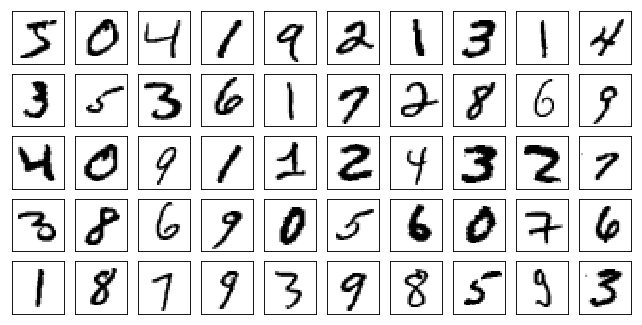

In [3]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))            
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        
        return x
    
    def loss(self, output, target, **kwargs):           
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [8]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [10]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.327237 drop: 2.327067 plain: 2.398716
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 1.940708 drop: 2.064648 plain: 2.166881
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.701396 drop: 1.560394 plain: 1.792192
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 1.356526 drop: 1.018548 plain: 1.202888
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 0.990829 drop: 0.651022 plain: 0.738635
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.963648 drop: 0.721057 plain: 0.716659
Test set:
bn: Loss: 0.9073	Accuracy: 8850.0/10000 (88%)
drop: Loss: 0.6407	Accuracy: 8445.0/10000 (84%)
plain: Loss: 0.6657	Accuracy: 8510.0/10000 (85%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.997129 drop: 0.727063 plain: 0.745833
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.682070 drop: 0.406315 plain: 0.428687
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.486867 drop: 0.359889 plain: 0.347797
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.545352 drop: 0.371274 plain: 0.34

Train Epoch: 13 [30000/50000 (60%)]	Losses bn: 0.097599 drop: 0.141717 plain: 0.099757
Train Epoch: 13 [40000/50000 (80%)]	Losses bn: 0.087630 drop: 0.099346 plain: 0.125132
Train Epoch: 13 [50000/50000 (100%)]	Losses bn: 0.072654 drop: 0.091802 plain: 0.093036
Test set:
bn: Loss: 0.0702	Accuracy: 9790.0/10000 (98%)
drop: Loss: 0.0874	Accuracy: 9761.0/10000 (98%)
plain: Loss: 0.0818	Accuracy: 9784.0/10000 (98%)

Train Epoch: 14 [0/50000 (0%)]	Losses bn: 0.029795 drop: 0.061071 plain: 0.057620
Train Epoch: 14 [10000/50000 (20%)]	Losses bn: 0.078697 drop: 0.104760 plain: 0.097463
Train Epoch: 14 [20000/50000 (40%)]	Losses bn: 0.039354 drop: 0.049134 plain: 0.053806
Train Epoch: 14 [30000/50000 (60%)]	Losses bn: 0.115576 drop: 0.137587 plain: 0.077492
Train Epoch: 14 [40000/50000 (80%)]	Losses bn: 0.049868 drop: 0.040388 plain: 0.031665
Train Epoch: 14 [50000/50000 (100%)]	Losses bn: 0.050742 drop: 0.038363 plain: 0.041651
Test set:
bn: Loss: 0.0659	Accuracy: 9822.0/10000 (98%)
drop: Loss

Train Epoch: 25 [50000/50000 (100%)]	Losses bn: 0.062874 drop: 0.063268 plain: 0.067614
Test set:
bn: Loss: 0.0466	Accuracy: 9864.0/10000 (99%)
drop: Loss: 0.0584	Accuracy: 9846.0/10000 (98%)
plain: Loss: 0.0562	Accuracy: 9838.0/10000 (98%)

Train Epoch: 26 [0/50000 (0%)]	Losses bn: 0.026951 drop: 0.027114 plain: 0.026477
Train Epoch: 26 [10000/50000 (20%)]	Losses bn: 0.022352 drop: 0.034438 plain: 0.032168
Train Epoch: 26 [20000/50000 (40%)]	Losses bn: 0.020409 drop: 0.032141 plain: 0.032243
Train Epoch: 26 [30000/50000 (60%)]	Losses bn: 0.005217 drop: 0.033979 plain: 0.023460
Train Epoch: 26 [40000/50000 (80%)]	Losses bn: 0.025118 drop: 0.013730 plain: 0.014087
Train Epoch: 26 [50000/50000 (100%)]	Losses bn: 0.044910 drop: 0.037579 plain: 0.045741
Test set:
bn: Loss: 0.0484	Accuracy: 9867.0/10000 (99%)
drop: Loss: 0.0591	Accuracy: 9844.0/10000 (98%)
plain: Loss: 0.0568	Accuracy: 9841.0/10000 (98%)

Train Epoch: 27 [0/50000 (0%)]	Losses bn: 0.018049 drop: 0.011464 plain: 0.011011
Trai

Train Epoch: 38 [10000/50000 (20%)]	Losses bn: 0.005484 drop: 0.023479 plain: 0.014725
Train Epoch: 38 [20000/50000 (40%)]	Losses bn: 0.021665 drop: 0.028262 plain: 0.029909
Train Epoch: 38 [30000/50000 (60%)]	Losses bn: 0.003145 drop: 0.008260 plain: 0.005832
Train Epoch: 38 [40000/50000 (80%)]	Losses bn: 0.017277 drop: 0.018855 plain: 0.023037
Train Epoch: 38 [50000/50000 (100%)]	Losses bn: 0.071951 drop: 0.054389 plain: 0.047094
Test set:
bn: Loss: 0.0425	Accuracy: 9877.0/10000 (99%)
drop: Loss: 0.0506	Accuracy: 9862.0/10000 (99%)
plain: Loss: 0.0484	Accuracy: 9858.0/10000 (99%)

Train Epoch: 39 [0/50000 (0%)]	Losses bn: 0.003092 drop: 0.005656 plain: 0.006828
Train Epoch: 39 [10000/50000 (20%)]	Losses bn: 0.009749 drop: 0.012060 plain: 0.008190
Train Epoch: 39 [20000/50000 (40%)]	Losses bn: 0.024282 drop: 0.028808 plain: 0.028665
Train Epoch: 39 [30000/50000 (60%)]	Losses bn: 0.031108 drop: 0.047713 plain: 0.055226
Train Epoch: 39 [40000/50000 (80%)]	Losses bn: 0.002226 drop: 0.009

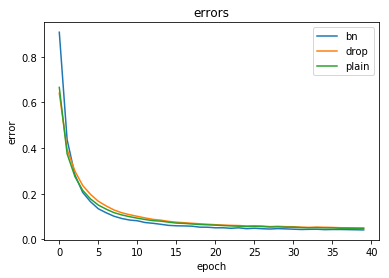

In [11]:
plot_graphs(test_log, 'loss')

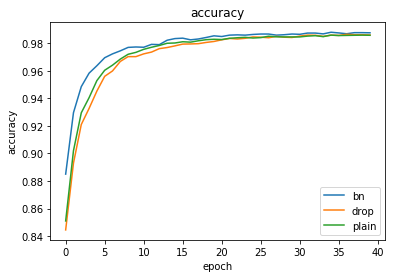

In [12]:
plot_graphs(test_log, 'accuracy')

In [13]:
torch.save(models['bn'], './model_classifier_convs')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Оптимизация изображений

In [9]:
model = torch.load('./model_classifier_convs')

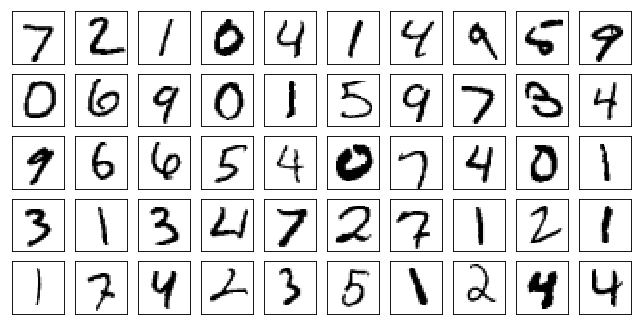

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [16]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

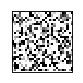

In [17]:
data, _ = next(iter(test_loader))
#img = data[2].view(-1, 1, 28, 28)
img = torch.randn((1, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))


In [18]:
from torch.autograd import Variable

def generate_image(img, cl):
    
    gen_img_par = Variable(img, requires_grad=True)    
    target = torch.ones((1), dtype=torch.long) * cl
    steps_since_lr_decreased = 0
    #target[cl] = 1
    #target = target.view(1, 10)
    
    loss_stats = []    
    lr = 1e-1
    
    for i in range(1, 10000001):  
             
        out = model.forward(gen_img_par)        
             
        gen_optim = optim.RMSprop([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        loss = F.cross_entropy(out, target)    
        loss.backward()          
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={} prediction={} lr={}".format(i,loss, out.argmax(), lr))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #1print("PRED=", out.argmax())
            #print("OUT=", out)
            #print("TR=", target)
                       
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 1))
       
   
                        
    return gen_img_par, loss_stats    

Iteration 5000: loss=8.467893053420994e-11 prediction=5 lr=0.1
Iteration 10000: loss=4.693845312431222e-11 prediction=5 lr=0.1
Iteration 15000: loss=2.9469759965650155e-11 prediction=5 lr=0.1
Iteration 20000: loss=2.4634516648802673e-11 prediction=5 lr=0.1
Iteration 25000: loss=2.190958525716269e-11 prediction=5 lr=0.1
Iteration 30000: loss=1.9845458609779598e-11 prediction=5 lr=0.1
Iteration 35000: loss=1.8189894035458565e-11 prediction=5 lr=0.1
Iteration 40000: loss=1.6679990721968352e-11 prediction=5 lr=0.1
Iteration 45000: loss=1.5191403690550942e-11 prediction=5 lr=0.1
Iteration 50000: loss=1.3852030633643153e-11 prediction=5 lr=0.1


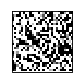

Iteration 55000: loss=1.2672529692281387e-11 prediction=5 lr=0.1
Iteration 60000: loss=1.1663559007502045e-11 prediction=5 lr=0.1
Iteration 65000: loss=1.0857093002414331e-11 prediction=5 lr=0.1
Iteration 70000: loss=1.0171419262405834e-11 prediction=5 lr=0.1
Iteration 75000: loss=9.595879646440153e-12 prediction=5 lr=0.1
Iteration 80000: loss=9.091394304050482e-12 prediction=5 lr=0.1
Iteration 85000: loss=8.64730509420042e-12 prediction=5 lr=0.1
Iteration 90000: loss=8.270717444247566e-12 prediction=5 lr=0.1
Iteration 95000: loss=7.94386778579792e-12 prediction=5 lr=0.1
Iteration 100000: loss=7.65965069149388e-12 prediction=5 lr=0.1


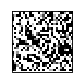

Iteration 105000: loss=7.410960733977845e-12 prediction=5 lr=0.1
Iteration 110000: loss=7.187139772213413e-12 prediction=5 lr=0.1
Iteration 115000: loss=6.984635092521785e-12 prediction=5 lr=0.1
Iteration 120000: loss=6.799893981224159e-12 prediction=5 lr=0.1
Iteration 125000: loss=6.629363724641735e-12 prediction=5 lr=0.1
Iteration 130000: loss=6.476597036453313e-12 prediction=5 lr=0.1
Iteration 135000: loss=6.334488489301293e-12 prediction=5 lr=0.1
Iteration 140000: loss=6.206590796864475e-12 prediction=5 lr=0.1
Iteration 145000: loss=6.0893512454640586e-12 prediction=5 lr=0.1
Iteration 150000: loss=5.979217121421243e-12 prediction=5 lr=0.1


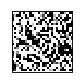

Iteration 155000: loss=5.8761884247360285e-12 prediction=5 lr=0.1
Iteration 160000: loss=5.780265155408415e-12 prediction=5 lr=0.1
Iteration 165000: loss=5.6843418860808015e-12 prediction=5 lr=0.1
Iteration 170000: loss=5.595524044110789e-12 prediction=5 lr=0.1
Iteration 175000: loss=5.5067062021407764e-12 prediction=5 lr=0.1
Iteration 180000: loss=5.4285465012071654e-12 prediction=5 lr=0.1
Iteration 185000: loss=5.353939513952355e-12 prediction=5 lr=0.1
Iteration 190000: loss=5.279332526697544e-12 prediction=5 lr=0.1
Iteration 195000: loss=5.211830966800335e-12 prediction=5 lr=0.1
Iteration 200000: loss=5.147882120581926e-12 prediction=5 lr=0.1


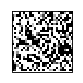

Iteration 205000: loss=5.091038701721118e-12 prediction=5 lr=0.1
Iteration 210000: loss=5.03419528286031e-12 prediction=5 lr=0.1
Iteration 215000: loss=4.984457291357103e-12 prediction=5 lr=0.1
Iteration 220000: loss=4.934719299853896e-12 prediction=5 lr=0.1
Iteration 225000: loss=4.888534022029489e-12 prediction=5 lr=0.1
Iteration 230000: loss=4.845901457883883e-12 prediction=5 lr=0.1
Iteration 235000: loss=4.803268893738277e-12 prediction=5 lr=0.1
Iteration 240000: loss=4.764189043271472e-12 prediction=5 lr=0.1
Iteration 245000: loss=4.728661906483467e-12 prediction=5 lr=0.1
Iteration 250000: loss=4.693134769695462e-12 prediction=5 lr=0.1


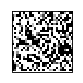

Iteration 255000: loss=4.657607632907457e-12 prediction=5 lr=0.1
Iteration 260000: loss=4.625633209798252e-12 prediction=5 lr=0.1
Iteration 265000: loss=4.593658786689048e-12 prediction=5 lr=0.1
Iteration 270000: loss=4.561684363579843e-12 prediction=5 lr=0.1
Iteration 275000: loss=4.533262654149439e-12 prediction=5 lr=0.1
Iteration 280000: loss=4.504840944719035e-12 prediction=5 lr=0.1
Iteration 285000: loss=4.476419235288631e-12 prediction=5 lr=0.1
Iteration 290000: loss=4.447997525858227e-12 prediction=5 lr=0.1
Iteration 295000: loss=4.423128530106624e-12 prediction=5 lr=0.1
Iteration 300000: loss=4.39470682067622e-12 prediction=5 lr=0.1


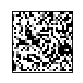

Iteration 305000: loss=4.369837824924616e-12 prediction=5 lr=0.1
Iteration 310000: loss=4.344968829173013e-12 prediction=5 lr=0.1
Iteration 315000: loss=4.32365254710021e-12 prediction=5 lr=0.1
Iteration 320000: loss=4.298783551348606e-12 prediction=5 lr=0.1
Iteration 325000: loss=4.273914555597003e-12 prediction=5 lr=0.1
Iteration 330000: loss=4.2525982735242e-12 prediction=5 lr=0.1
Iteration 335000: loss=4.227729277772596e-12 prediction=5 lr=0.1
Iteration 340000: loss=4.206412995699793e-12 prediction=5 lr=0.1
Iteration 345000: loss=4.1815439999481896e-12 prediction=5 lr=0.1
Iteration 350000: loss=4.1602277178753866e-12 prediction=5 lr=0.1


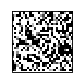

Iteration 355000: loss=4.1389114358025836e-12 prediction=5 lr=0.1
Iteration 360000: loss=4.1175951537297806e-12 prediction=5 lr=0.1
Iteration 365000: loss=4.0962788716569776e-12 prediction=5 lr=0.1
Iteration 370000: loss=4.0749625895841746e-12 prediction=5 lr=0.1
Iteration 375000: loss=4.057199021190172e-12 prediction=5 lr=0.1
Iteration 380000: loss=4.035882739117369e-12 prediction=5 lr=0.1
Iteration 385000: loss=4.0181191707233666e-12 prediction=5 lr=0.1
Iteration 390000: loss=4.000355602329364e-12 prediction=5 lr=0.1
Iteration 395000: loss=3.979039320256561e-12 prediction=5 lr=0.1
Iteration 400000: loss=3.9612757518625585e-12 prediction=5 lr=0.1


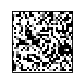

Iteration 405000: loss=3.943512183468556e-12 prediction=5 lr=0.1
Iteration 410000: loss=3.9257486150745535e-12 prediction=5 lr=0.1
Iteration 415000: loss=3.907985046680551e-12 prediction=5 lr=0.1
Iteration 420000: loss=3.886668764607748e-12 prediction=5 lr=0.1
Iteration 425000: loss=3.8689051962137455e-12 prediction=5 lr=0.1
Iteration 430000: loss=3.851141627819743e-12 prediction=5 lr=0.1
Iteration 435000: loss=3.8333780594257405e-12 prediction=5 lr=0.1
Iteration 440000: loss=3.815614491031738e-12 prediction=5 lr=0.1
Iteration 445000: loss=3.7978509226377355e-12 prediction=5 lr=0.1
Iteration 450000: loss=3.780087354243733e-12 prediction=5 lr=0.1


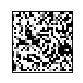

Iteration 455000: loss=3.7623237858497305e-12 prediction=5 lr=0.1
Iteration 460000: loss=3.744560217455728e-12 prediction=5 lr=0.1
Iteration 465000: loss=3.7267966490617255e-12 prediction=5 lr=0.1
Iteration 470000: loss=3.709033080667723e-12 prediction=5 lr=0.1
Iteration 475000: loss=3.68771679859492e-12 prediction=5 lr=0.1
Iteration 480000: loss=3.666400516522117e-12 prediction=5 lr=0.1
Iteration 485000: loss=3.645084234449314e-12 prediction=5 lr=0.1
Iteration 490000: loss=3.623767952376511e-12 prediction=5 lr=0.1
Iteration 495000: loss=3.5988989566249074e-12 prediction=5 lr=0.1
Iteration 500000: loss=3.574029960873304e-12 prediction=5 lr=0.1


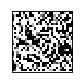

Iteration 505000: loss=3.5456082514429e-12 prediction=5 lr=0.1
Iteration 510000: loss=3.510081114654895e-12 prediction=5 lr=0.1
Iteration 515000: loss=3.467448550509289e-12 prediction=5 lr=0.1
Iteration 520000: loss=3.417710559006082e-12 prediction=5 lr=0.1
Iteration 525000: loss=3.3786307085392764e-12 prediction=5 lr=0.1
Iteration 530000: loss=3.339550858072471e-12 prediction=5 lr=0.1
Iteration 535000: loss=3.3004710076056654e-12 prediction=5 lr=0.1
Iteration 540000: loss=3.2578384434600594e-12 prediction=5 lr=0.1
Iteration 545000: loss=3.2152058793144533e-12 prediction=5 lr=0.1
Iteration 550000: loss=3.1725733151688473e-12 prediction=5 lr=0.1


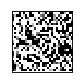

Iteration 555000: loss=3.1299407510232413e-12 prediction=5 lr=0.1
Iteration 560000: loss=3.090860900556436e-12 prediction=5 lr=0.1
Iteration 565000: loss=3.055333763768431e-12 prediction=5 lr=0.1
Iteration 570000: loss=3.0233593406592263e-12 prediction=5 lr=0.1
Iteration 575000: loss=2.9913849175500218e-12 prediction=5 lr=0.1
Iteration 580000: loss=2.9665159217984183e-12 prediction=5 lr=0.1
Iteration 585000: loss=2.9416469260468148e-12 prediction=5 lr=0.1
Iteration 590000: loss=2.9203306439740118e-12 prediction=5 lr=0.1
Iteration 595000: loss=2.9025670755800093e-12 prediction=5 lr=0.1
Iteration 600000: loss=2.8848035071860068e-12 prediction=5 lr=0.1


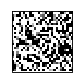

Iteration 605000: loss=2.8670399387920042e-12 prediction=5 lr=0.1
Iteration 610000: loss=2.8528290840768022e-12 prediction=5 lr=0.1
Iteration 615000: loss=2.8386182293616002e-12 prediction=5 lr=0.1
Iteration 620000: loss=2.8244073746463982e-12 prediction=5 lr=0.1
Iteration 625000: loss=2.8101965199311962e-12 prediction=5 lr=0.1
Iteration 630000: loss=2.7995383788947947e-12 prediction=5 lr=0.1
Iteration 635000: loss=2.7853275241795927e-12 prediction=5 lr=0.1
Iteration 640000: loss=2.7746693831431912e-12 prediction=5 lr=0.1
Iteration 645000: loss=2.7640112421067897e-12 prediction=5 lr=0.1
Iteration 650000: loss=2.7533531010703882e-12 prediction=5 lr=0.1


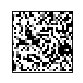

Iteration 655000: loss=2.7426949600339867e-12 prediction=5 lr=0.1
Iteration 660000: loss=2.7355895326763857e-12 prediction=5 lr=0.1
Iteration 665000: loss=2.7249313916399842e-12 prediction=5 lr=0.1
Iteration 670000: loss=2.7142732506035827e-12 prediction=5 lr=0.1
Iteration 675000: loss=2.7071678232459817e-12 prediction=5 lr=0.1
Iteration 680000: loss=2.6965096822095802e-12 prediction=5 lr=0.1
Iteration 685000: loss=2.6894042548519792e-12 prediction=5 lr=0.1
Iteration 690000: loss=2.6787461138155777e-12 prediction=5 lr=0.1
Iteration 695000: loss=2.6716406864579767e-12 prediction=5 lr=0.1
Iteration 700000: loss=2.660982545421575e-12 prediction=5 lr=0.1


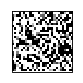

Iteration 705000: loss=2.653877118063974e-12 prediction=5 lr=0.1
Iteration 710000: loss=2.646771690706373e-12 prediction=5 lr=0.1
Iteration 715000: loss=2.6361135496699717e-12 prediction=5 lr=0.1
Iteration 720000: loss=2.6290081223123707e-12 prediction=5 lr=0.1
Iteration 725000: loss=2.6219026949547697e-12 prediction=5 lr=0.1
Iteration 730000: loss=2.6147972675971687e-12 prediction=5 lr=0.1
Iteration 735000: loss=2.6076918402395677e-12 prediction=5 lr=0.1
Iteration 740000: loss=2.6005864128819667e-12 prediction=5 lr=0.1
Iteration 745000: loss=2.589928271845565e-12 prediction=5 lr=0.1
Iteration 750000: loss=2.582822844487964e-12 prediction=5 lr=0.1


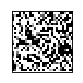

Iteration 755000: loss=2.575717417130363e-12 prediction=5 lr=0.1
Iteration 760000: loss=2.568611989772762e-12 prediction=5 lr=0.1
Iteration 765000: loss=2.561506562415161e-12 prediction=5 lr=0.1
Iteration 770000: loss=2.55440113505756e-12 prediction=5 lr=0.1
Iteration 775000: loss=2.547295707699959e-12 prediction=5 lr=0.1
Iteration 780000: loss=2.5366375666635577e-12 prediction=5 lr=0.1
Iteration 785000: loss=2.5295321393059567e-12 prediction=5 lr=0.1
Iteration 790000: loss=2.5224267119483557e-12 prediction=5 lr=0.1
Iteration 795000: loss=2.5153212845907547e-12 prediction=5 lr=0.1
Iteration 800000: loss=2.5082158572331537e-12 prediction=5 lr=0.1


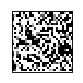

Iteration 805000: loss=2.497557716196752e-12 prediction=5 lr=0.1
Iteration 810000: loss=2.490452288839151e-12 prediction=5 lr=0.1
Iteration 815000: loss=2.48334686148155e-12 prediction=5 lr=0.1
Iteration 820000: loss=2.476241434123949e-12 prediction=5 lr=0.1
Iteration 825000: loss=2.469136006766348e-12 prediction=5 lr=0.1
Iteration 830000: loss=2.4584778657299466e-12 prediction=5 lr=0.1
Iteration 835000: loss=2.4513724383723456e-12 prediction=5 lr=0.1
Iteration 840000: loss=2.4442670110147446e-12 prediction=5 lr=0.1
Iteration 845000: loss=2.4371615836571436e-12 prediction=5 lr=0.1
Iteration 850000: loss=2.4300561562995426e-12 prediction=5 lr=0.1


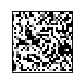

Iteration 855000: loss=2.4229507289419416e-12 prediction=5 lr=0.1
Iteration 860000: loss=2.41229258790554e-12 prediction=5 lr=0.1
Iteration 865000: loss=2.405187160547939e-12 prediction=5 lr=0.1
Iteration 870000: loss=2.398081733190338e-12 prediction=5 lr=0.1
Iteration 875000: loss=2.390976305832737e-12 prediction=5 lr=0.1
Iteration 880000: loss=2.383870878475136e-12 prediction=5 lr=0.1
Iteration 885000: loss=2.376765451117535e-12 prediction=5 lr=0.1
Iteration 890000: loss=2.3732127374387346e-12 prediction=5 lr=0.1
Iteration 895000: loss=2.3661073100811336e-12 prediction=5 lr=0.1
Iteration 900000: loss=2.3590018827235326e-12 prediction=5 lr=0.1


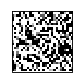

Iteration 905000: loss=2.3518964553659316e-12 prediction=5 lr=0.1
Iteration 910000: loss=2.3447910280083306e-12 prediction=5 lr=0.1
Iteration 915000: loss=2.3376856006507296e-12 prediction=5 lr=0.1
Iteration 920000: loss=2.334132886971929e-12 prediction=5 lr=0.1
Iteration 925000: loss=2.327027459614328e-12 prediction=5 lr=0.1
Iteration 930000: loss=2.319922032256727e-12 prediction=5 lr=0.1
Iteration 935000: loss=2.312816604899126e-12 prediction=5 lr=0.1
Iteration 940000: loss=2.3092638912203256e-12 prediction=5 lr=0.1
Iteration 945000: loss=2.3021584638627246e-12 prediction=5 lr=0.1
Iteration 950000: loss=2.2950530365051236e-12 prediction=5 lr=0.1


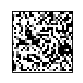

Iteration 955000: loss=2.2879476091475226e-12 prediction=5 lr=0.1
Iteration 960000: loss=2.284394895468722e-12 prediction=5 lr=0.1
Iteration 965000: loss=2.277289468111121e-12 prediction=5 lr=0.1
Iteration 970000: loss=2.27018404075352e-12 prediction=5 lr=0.1
Iteration 975000: loss=2.2666313270747196e-12 prediction=5 lr=0.1
Iteration 980000: loss=2.2595258997171186e-12 prediction=5 lr=0.1
Iteration 985000: loss=2.2524204723595176e-12 prediction=5 lr=0.1
Iteration 990000: loss=2.2453150450019166e-12 prediction=5 lr=0.1
Iteration 995000: loss=2.241762331323116e-12 prediction=5 lr=0.1
Iteration 1000000: loss=2.234656903965515e-12 prediction=5 lr=0.1


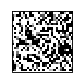

Iteration 1005000: loss=2.227551476607914e-12 prediction=5 lr=0.1
Iteration 1010000: loss=2.220446049250313e-12 prediction=5 lr=0.1
Iteration 1015000: loss=2.2168933355715126e-12 prediction=5 lr=0.1
Iteration 1020000: loss=2.2097879082139116e-12 prediction=5 lr=0.1
Iteration 1025000: loss=2.2026824808563106e-12 prediction=5 lr=0.1
Iteration 1030000: loss=2.1955770534987096e-12 prediction=5 lr=0.1
Iteration 1035000: loss=2.192024339819909e-12 prediction=5 lr=0.1
Iteration 1040000: loss=2.184918912462308e-12 prediction=5 lr=0.1
Iteration 1045000: loss=2.177813485104707e-12 prediction=5 lr=0.1
Iteration 1050000: loss=2.170708057747106e-12 prediction=5 lr=0.1


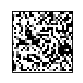

Iteration 1055000: loss=2.163602630389505e-12 prediction=5 lr=0.1
Iteration 1060000: loss=2.1600499167107046e-12 prediction=5 lr=0.1
Iteration 1065000: loss=2.1529444893531036e-12 prediction=5 lr=0.1
Iteration 1070000: loss=2.1458390619955026e-12 prediction=5 lr=0.1
Iteration 1075000: loss=2.1387336346379016e-12 prediction=5 lr=0.1
Iteration 1080000: loss=2.1316282072803006e-12 prediction=5 lr=0.1
Iteration 1085000: loss=2.1245227799226996e-12 prediction=5 lr=0.1
Iteration 1090000: loss=2.1174173525650986e-12 prediction=5 lr=0.1
Iteration 1095000: loss=2.1103119252074976e-12 prediction=5 lr=0.1
Iteration 1100000: loss=2.1032064978498966e-12 prediction=5 lr=0.1


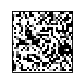

Iteration 1105000: loss=2.0961010704922955e-12 prediction=5 lr=0.1
Iteration 1110000: loss=2.0889956431346945e-12 prediction=5 lr=0.1
Iteration 1115000: loss=2.0818902157770935e-12 prediction=5 lr=0.1
Iteration 1120000: loss=2.0747847884194925e-12 prediction=5 lr=0.1
Iteration 1125000: loss=2.0676793610618915e-12 prediction=5 lr=0.1
Iteration 1130000: loss=2.0605739337042905e-12 prediction=5 lr=0.1
Iteration 1135000: loss=2.0534685063466895e-12 prediction=5 lr=0.1
Iteration 1140000: loss=2.042810365310288e-12 prediction=5 lr=0.1
Iteration 1145000: loss=2.035704937952687e-12 prediction=5 lr=0.1
Iteration 1150000: loss=2.028599510595086e-12 prediction=5 lr=0.1


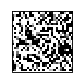

Iteration 1155000: loss=2.021494083237485e-12 prediction=5 lr=0.1
Iteration 1160000: loss=2.0108359422010835e-12 prediction=5 lr=0.1
Iteration 1165000: loss=2.0037305148434825e-12 prediction=5 lr=0.1
Iteration 1170000: loss=1.993072373807081e-12 prediction=5 lr=0.1
Iteration 1175000: loss=1.98596694644948e-12 prediction=5 lr=0.1
Iteration 1180000: loss=1.9753088054130785e-12 prediction=5 lr=0.1
Iteration 1185000: loss=1.9682033780554775e-12 prediction=5 lr=0.1
Iteration 1190000: loss=1.957545237019076e-12 prediction=5 lr=0.1
Iteration 1195000: loss=1.9468870959826745e-12 prediction=5 lr=0.1
Iteration 1200000: loss=1.9397816686250735e-12 prediction=5 lr=0.1


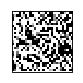

Iteration 1205000: loss=1.936228954946273e-12 prediction=5 lr=0.1
Iteration 1210000: loss=1.9255708139098715e-12 prediction=5 lr=0.1
Iteration 1215000: loss=1.9184653865522705e-12 prediction=5 lr=0.1
Iteration 1220000: loss=1.91491267287347e-12 prediction=5 lr=0.1
Iteration 1225000: loss=1.9042545318370685e-12 prediction=5 lr=0.1
Iteration 1230000: loss=1.8971491044794675e-12 prediction=5 lr=0.1
Iteration 1235000: loss=1.8900436771218665e-12 prediction=5 lr=0.1
Iteration 1240000: loss=1.8829382497642655e-12 prediction=5 lr=0.1
Iteration 1245000: loss=1.8758328224066645e-12 prediction=5 lr=0.1
Iteration 1250000: loss=1.8687273950490635e-12 prediction=5 lr=0.1


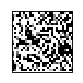

Iteration 1255000: loss=1.8616219676914625e-12 prediction=5 lr=0.1
Iteration 1260000: loss=1.8545165403338615e-12 prediction=5 lr=0.1
Iteration 1265000: loss=1.8474111129762605e-12 prediction=5 lr=0.1
Iteration 1270000: loss=1.8403056856186595e-12 prediction=5 lr=0.1
Iteration 1275000: loss=1.8332002582610585e-12 prediction=5 lr=0.1
Iteration 1280000: loss=1.8260948309034575e-12 prediction=5 lr=0.1
Iteration 1285000: loss=1.8189894035458565e-12 prediction=5 lr=0.1
Iteration 1290000: loss=1.8118839761882555e-12 prediction=5 lr=0.1
Iteration 1295000: loss=1.8047785488306545e-12 prediction=5 lr=0.1
Iteration 1300000: loss=1.7976731214730535e-12 prediction=5 lr=0.1


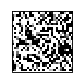

Iteration 1305000: loss=1.7905676941154525e-12 prediction=5 lr=0.1
Iteration 1310000: loss=1.779909553079051e-12 prediction=5 lr=0.1
Iteration 1315000: loss=1.77280412572145e-12 prediction=5 lr=0.1
Iteration 1320000: loss=1.765698698363849e-12 prediction=5 lr=0.1
Iteration 1325000: loss=1.758593271006248e-12 prediction=5 lr=0.1
Iteration 1330000: loss=1.7479351299698465e-12 prediction=5 lr=0.1
Iteration 1335000: loss=1.7408297026122455e-12 prediction=5 lr=0.1
Iteration 1340000: loss=1.730171561575844e-12 prediction=5 lr=0.1
Iteration 1345000: loss=1.723066134218243e-12 prediction=5 lr=0.1
Iteration 1350000: loss=1.7124079931818414e-12 prediction=5 lr=0.1


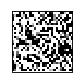

Iteration 1355000: loss=1.70174985214544e-12 prediction=5 lr=0.1
Iteration 1360000: loss=1.694644424787839e-12 prediction=5 lr=0.1
Iteration 1365000: loss=1.687538997430238e-12 prediction=5 lr=0.1
Iteration 1370000: loss=1.680433570072637e-12 prediction=5 lr=0.1
Iteration 1375000: loss=1.6697754290362354e-12 prediction=5 lr=0.1
Iteration 1380000: loss=1.6626700016786344e-12 prediction=5 lr=0.1
Iteration 1385000: loss=1.6555645743210334e-12 prediction=5 lr=0.1
Iteration 1390000: loss=1.6484591469634324e-12 prediction=5 lr=0.1
Iteration 1395000: loss=1.6413537196058314e-12 prediction=5 lr=0.1
Iteration 1400000: loss=1.6342482922482304e-12 prediction=5 lr=0.1


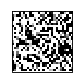

Iteration 1405000: loss=1.623590151211829e-12 prediction=5 lr=0.1
Iteration 1410000: loss=1.616484723854228e-12 prediction=5 lr=0.1
Iteration 1415000: loss=1.609379296496627e-12 prediction=5 lr=0.1
Iteration 1420000: loss=1.5987211554602254e-12 prediction=5 lr=0.1
Iteration 1425000: loss=1.5916157281026244e-12 prediction=5 lr=0.1
Iteration 1430000: loss=1.5845103007450234e-12 prediction=5 lr=0.1
Iteration 1435000: loss=1.5774048733874224e-12 prediction=5 lr=0.1
Iteration 1440000: loss=1.566746732351021e-12 prediction=5 lr=0.1
Iteration 1445000: loss=1.55964130499342e-12 prediction=5 lr=0.1
Iteration 1450000: loss=1.552535877635819e-12 prediction=5 lr=0.1


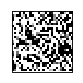

Iteration 1455000: loss=1.545430450278218e-12 prediction=5 lr=0.1
Iteration 1460000: loss=1.5347723092418164e-12 prediction=5 lr=0.1
Iteration 1465000: loss=1.5276668818842154e-12 prediction=5 lr=0.1
Iteration 1470000: loss=1.5205614545266144e-12 prediction=5 lr=0.1
Iteration 1475000: loss=1.5134560271690134e-12 prediction=5 lr=0.1
Iteration 1480000: loss=1.5063505998114124e-12 prediction=5 lr=0.1
Iteration 1485000: loss=1.5027978861326119e-12 prediction=5 lr=0.1
Iteration 1490000: loss=1.4956924587750109e-12 prediction=5 lr=0.1
Iteration 1495000: loss=1.4885870314174099e-12 prediction=5 lr=0.1
Iteration 1500000: loss=1.4850343177386094e-12 prediction=5 lr=0.1


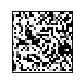

Iteration 1505000: loss=1.4779288903810084e-12 prediction=5 lr=0.1
Iteration 1510000: loss=1.4708234630234074e-12 prediction=5 lr=0.1
Iteration 1515000: loss=1.4672707493446069e-12 prediction=5 lr=0.1
Iteration 1520000: loss=1.4637180356658064e-12 prediction=5 lr=0.1
Iteration 1525000: loss=1.4566126083082054e-12 prediction=5 lr=0.1
Iteration 1530000: loss=1.4530598946294049e-12 prediction=5 lr=0.1
Iteration 1535000: loss=1.4459544672718039e-12 prediction=5 lr=0.1
Iteration 1540000: loss=1.4424017535930034e-12 prediction=5 lr=0.1
Iteration 1545000: loss=1.4388490399142029e-12 prediction=5 lr=0.1
Iteration 1550000: loss=1.4352963262354024e-12 prediction=5 lr=0.1


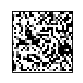

Iteration 1555000: loss=1.4281908988778014e-12 prediction=5 lr=0.1
Iteration 1560000: loss=1.4246381851990009e-12 prediction=5 lr=0.1
Iteration 1565000: loss=1.4210854715202004e-12 prediction=5 lr=0.1
Iteration 1570000: loss=1.4175327578413999e-12 prediction=5 lr=0.1
Iteration 1575000: loss=1.4139800441625994e-12 prediction=5 lr=0.1
Iteration 1580000: loss=1.4104273304837989e-12 prediction=5 lr=0.1
Iteration 1585000: loss=1.4068746168049984e-12 prediction=5 lr=0.1
Iteration 1590000: loss=1.4033219031261979e-12 prediction=5 lr=0.1
Iteration 1595000: loss=1.3962164757685969e-12 prediction=5 lr=0.1
Iteration 1600000: loss=1.3926637620897964e-12 prediction=5 lr=0.1


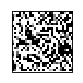

Iteration 1605000: loss=1.3926637620897964e-12 prediction=5 lr=0.1
Iteration 1610000: loss=1.3891110484109959e-12 prediction=5 lr=0.1
Iteration 1615000: loss=1.3855583347321954e-12 prediction=5 lr=0.1
Iteration 1620000: loss=1.3820056210533949e-12 prediction=5 lr=0.1
Iteration 1625000: loss=1.3784529073745944e-12 prediction=5 lr=0.1
Iteration 1630000: loss=1.3749001936957939e-12 prediction=5 lr=0.1
Iteration 1635000: loss=1.3713474800169934e-12 prediction=5 lr=0.1
Iteration 1640000: loss=1.3677947663381929e-12 prediction=5 lr=0.1
Iteration 1645000: loss=1.3642420526593924e-12 prediction=5 lr=0.1
Iteration 1650000: loss=1.3642420526593924e-12 prediction=5 lr=0.1


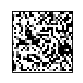

Iteration 1655000: loss=1.3606893389805919e-12 prediction=5 lr=0.1
Iteration 1660000: loss=1.3571366253017914e-12 prediction=5 lr=0.1
Iteration 1665000: loss=1.3535839116229909e-12 prediction=5 lr=0.1
Iteration 1670000: loss=1.3535839116229909e-12 prediction=5 lr=0.1
Iteration 1675000: loss=1.3500311979441904e-12 prediction=5 lr=0.1
Iteration 1680000: loss=1.3464784842653899e-12 prediction=5 lr=0.1
Iteration 1685000: loss=1.3429257705865894e-12 prediction=5 lr=0.1
Iteration 1690000: loss=1.3429257705865894e-12 prediction=5 lr=0.1
Iteration 1695000: loss=1.3393730569077889e-12 prediction=5 lr=0.1
Iteration 1700000: loss=1.3358203432289883e-12 prediction=5 lr=0.1


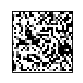

Iteration 1705000: loss=1.3322676295501878e-12 prediction=5 lr=0.1
Iteration 1710000: loss=1.3322676295501878e-12 prediction=5 lr=0.1
Iteration 1715000: loss=1.3287149158713873e-12 prediction=5 lr=0.1
Iteration 1720000: loss=1.3251622021925868e-12 prediction=5 lr=0.1
Iteration 1725000: loss=1.3251622021925868e-12 prediction=5 lr=0.1
Iteration 1730000: loss=1.3216094885137863e-12 prediction=5 lr=0.1
Iteration 1735000: loss=1.3180567748349858e-12 prediction=5 lr=0.1
Iteration 1740000: loss=1.3180567748349858e-12 prediction=5 lr=0.1
Iteration 1745000: loss=1.3145040611561853e-12 prediction=5 lr=0.1
Iteration 1750000: loss=1.3109513474773848e-12 prediction=5 lr=0.1


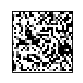

Iteration 1755000: loss=1.3109513474773848e-12 prediction=5 lr=0.1
Iteration 1760000: loss=1.3073986337985843e-12 prediction=5 lr=0.1
Iteration 1765000: loss=1.3038459201197838e-12 prediction=5 lr=0.1
Iteration 1770000: loss=1.3038459201197838e-12 prediction=5 lr=0.1
Iteration 1775000: loss=1.3002932064409833e-12 prediction=5 lr=0.1
Iteration 1780000: loss=1.2967404927621828e-12 prediction=5 lr=0.1
Iteration 1785000: loss=1.2967404927621828e-12 prediction=5 lr=0.1
Iteration 1790000: loss=1.2931877790833823e-12 prediction=5 lr=0.1
Iteration 1795000: loss=1.2896350654045818e-12 prediction=5 lr=0.1
Iteration 1800000: loss=1.2896350654045818e-12 prediction=5 lr=0.1


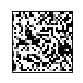

Iteration 1805000: loss=1.2860823517257813e-12 prediction=5 lr=0.1
Iteration 1810000: loss=1.2825296380469808e-12 prediction=5 lr=0.1
Iteration 1815000: loss=1.2825296380469808e-12 prediction=5 lr=0.1
Iteration 1820000: loss=1.2789769243681803e-12 prediction=5 lr=0.1
Iteration 1825000: loss=1.2754242106893798e-12 prediction=5 lr=0.1
Iteration 1830000: loss=1.2754242106893798e-12 prediction=5 lr=0.1
Iteration 1835000: loss=1.2718714970105793e-12 prediction=5 lr=0.1
Iteration 1840000: loss=1.2718714970105793e-12 prediction=5 lr=0.1
Iteration 1845000: loss=1.2683187833317788e-12 prediction=5 lr=0.1
Iteration 1850000: loss=1.2683187833317788e-12 prediction=5 lr=0.1


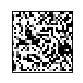

Iteration 1855000: loss=1.2647660696529783e-12 prediction=5 lr=0.1
Iteration 1860000: loss=1.2612133559741778e-12 prediction=5 lr=0.1
Iteration 1865000: loss=1.2612133559741778e-12 prediction=5 lr=0.1
Iteration 1870000: loss=1.2576606422953773e-12 prediction=5 lr=0.1
Iteration 1875000: loss=1.2541079286165768e-12 prediction=5 lr=0.1
Iteration 1880000: loss=1.2541079286165768e-12 prediction=5 lr=0.1
Iteration 1885000: loss=1.2505552149377763e-12 prediction=5 lr=0.1
Iteration 1890000: loss=1.2505552149377763e-12 prediction=5 lr=0.1
Iteration 1895000: loss=1.2470025012589758e-12 prediction=5 lr=0.1
Iteration 1900000: loss=1.2434497875801753e-12 prediction=5 lr=0.1


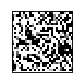

Iteration 1905000: loss=1.2434497875801753e-12 prediction=5 lr=0.1
Iteration 1910000: loss=1.2398970739013748e-12 prediction=5 lr=0.1
Iteration 1915000: loss=1.2363443602225743e-12 prediction=5 lr=0.1
Iteration 1920000: loss=1.2363443602225743e-12 prediction=5 lr=0.1
Iteration 1925000: loss=1.2327916465437738e-12 prediction=5 lr=0.1
Iteration 1930000: loss=1.2292389328649733e-12 prediction=5 lr=0.1
Iteration 1935000: loss=1.2292389328649733e-12 prediction=5 lr=0.1
Iteration 1940000: loss=1.2256862191861728e-12 prediction=5 lr=0.1
Iteration 1945000: loss=1.2221335055073723e-12 prediction=5 lr=0.1
Iteration 1950000: loss=1.2221335055073723e-12 prediction=5 lr=0.1


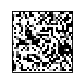

Iteration 1955000: loss=1.2185807918285718e-12 prediction=5 lr=0.1
Iteration 1960000: loss=1.2150280781497713e-12 prediction=5 lr=0.1
Iteration 1965000: loss=1.2114753644709708e-12 prediction=5 lr=0.1
Iteration 1970000: loss=1.2114753644709708e-12 prediction=5 lr=0.1
Iteration 1975000: loss=1.2079226507921703e-12 prediction=5 lr=0.1
Iteration 1980000: loss=1.2043699371133698e-12 prediction=5 lr=0.1
Iteration 1985000: loss=1.2008172234345693e-12 prediction=5 lr=0.1
Iteration 1990000: loss=1.1972645097557688e-12 prediction=5 lr=0.1
Iteration 1995000: loss=1.1972645097557688e-12 prediction=5 lr=0.1
Iteration 2000000: loss=1.1937117960769683e-12 prediction=5 lr=0.1


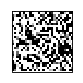

Iteration 2005000: loss=1.1901590823981678e-12 prediction=5 lr=0.1
Iteration 2010000: loss=1.1866063687193673e-12 prediction=5 lr=0.1
Iteration 2015000: loss=1.1830536550405668e-12 prediction=5 lr=0.1
Iteration 2020000: loss=1.1830536550405668e-12 prediction=5 lr=0.1
Iteration 2025000: loss=1.1795009413617663e-12 prediction=5 lr=0.1
Iteration 2030000: loss=1.1759482276829658e-12 prediction=5 lr=0.1
Iteration 2035000: loss=1.1723955140041653e-12 prediction=5 lr=0.1
Iteration 2040000: loss=1.1688428003253648e-12 prediction=5 lr=0.1
Iteration 2045000: loss=1.1652900866465643e-12 prediction=5 lr=0.1
Iteration 2050000: loss=1.1617373729677638e-12 prediction=5 lr=0.1


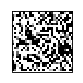

Iteration 2055000: loss=1.1617373729677638e-12 prediction=5 lr=0.1
Iteration 2060000: loss=1.1581846592889633e-12 prediction=5 lr=0.1
Iteration 2065000: loss=1.1546319456101628e-12 prediction=5 lr=0.1
Iteration 2070000: loss=1.1510792319313623e-12 prediction=5 lr=0.1
Iteration 2075000: loss=1.1475265182525618e-12 prediction=5 lr=0.1
Iteration 2080000: loss=1.1439738045737613e-12 prediction=5 lr=0.1
Iteration 2085000: loss=1.1404210908949608e-12 prediction=5 lr=0.1
Iteration 2090000: loss=1.1404210908949608e-12 prediction=5 lr=0.1
Iteration 2095000: loss=1.1368683772161603e-12 prediction=5 lr=0.1
Iteration 2100000: loss=1.1333156635373598e-12 prediction=5 lr=0.1


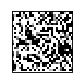

Iteration 2105000: loss=1.1297629498585593e-12 prediction=5 lr=0.1
Iteration 2110000: loss=1.1262102361797588e-12 prediction=5 lr=0.1
Iteration 2115000: loss=1.1262102361797588e-12 prediction=5 lr=0.1
Iteration 2120000: loss=1.1226575225009583e-12 prediction=5 lr=0.1
Iteration 2125000: loss=1.1191048088221578e-12 prediction=5 lr=0.1
Iteration 2130000: loss=1.1155520951433573e-12 prediction=5 lr=0.1
Iteration 2135000: loss=1.1155520951433573e-12 prediction=5 lr=0.1
Iteration 2140000: loss=1.1119993814645568e-12 prediction=5 lr=0.1
Iteration 2145000: loss=1.1084466677857563e-12 prediction=5 lr=0.1
Iteration 2150000: loss=1.1084466677857563e-12 prediction=5 lr=0.1


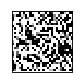

Iteration 2155000: loss=1.1048939541069558e-12 prediction=5 lr=0.1
Iteration 2160000: loss=1.1048939541069558e-12 prediction=5 lr=0.1
Iteration 2165000: loss=1.1013412404281553e-12 prediction=5 lr=0.1
Iteration 2170000: loss=1.0977885267493548e-12 prediction=5 lr=0.1
Iteration 2175000: loss=1.0977885267493548e-12 prediction=5 lr=0.1
Iteration 2180000: loss=1.0942358130705543e-12 prediction=5 lr=0.1
Iteration 2185000: loss=1.0942358130705543e-12 prediction=5 lr=0.1
Iteration 2190000: loss=1.0906830993917538e-12 prediction=5 lr=0.1
Iteration 2195000: loss=1.0906830993917538e-12 prediction=5 lr=0.1
Iteration 2200000: loss=1.0871303857129533e-12 prediction=5 lr=0.1


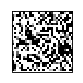

Iteration 2205000: loss=1.0835776720341528e-12 prediction=5 lr=0.1
Iteration 2210000: loss=1.0835776720341528e-12 prediction=5 lr=0.1
Iteration 2215000: loss=1.0800249583553523e-12 prediction=5 lr=0.1
Iteration 2220000: loss=1.0800249583553523e-12 prediction=5 lr=0.1
Iteration 2225000: loss=1.0764722446765518e-12 prediction=5 lr=0.1
Iteration 2230000: loss=1.0764722446765518e-12 prediction=5 lr=0.1
Iteration 2235000: loss=1.0764722446765518e-12 prediction=5 lr=0.1
Iteration 2240000: loss=1.0729195309977513e-12 prediction=5 lr=0.1
Iteration 2245000: loss=1.0729195309977513e-12 prediction=5 lr=0.1
Iteration 2250000: loss=1.0693668173189508e-12 prediction=5 lr=0.1


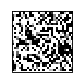

Iteration 2255000: loss=1.0693668173189508e-12 prediction=5 lr=0.1
Iteration 2260000: loss=1.0658141036401503e-12 prediction=5 lr=0.1
Iteration 2265000: loss=1.0658141036401503e-12 prediction=5 lr=0.1
Iteration 2270000: loss=1.0622613899613498e-12 prediction=5 lr=0.1
Iteration 2275000: loss=1.0622613899613498e-12 prediction=5 lr=0.1
Iteration 2280000: loss=1.0622613899613498e-12 prediction=5 lr=0.1
Iteration 2285000: loss=1.0587086762825493e-12 prediction=5 lr=0.1
Iteration 2290000: loss=1.0587086762825493e-12 prediction=5 lr=0.1
Iteration 2295000: loss=1.0587086762825493e-12 prediction=5 lr=0.1
Iteration 2300000: loss=1.0551559626037488e-12 prediction=5 lr=0.1


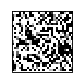

Iteration 2305000: loss=1.0551559626037488e-12 prediction=5 lr=0.1
Iteration 2310000: loss=1.0551559626037488e-12 prediction=5 lr=0.1
Iteration 2315000: loss=1.0516032489249483e-12 prediction=5 lr=0.1
Iteration 2320000: loss=1.0516032489249483e-12 prediction=5 lr=0.1
Iteration 2325000: loss=1.0480505352461478e-12 prediction=5 lr=0.1
Iteration 2330000: loss=1.0480505352461478e-12 prediction=5 lr=0.1
Iteration 2335000: loss=1.0480505352461478e-12 prediction=5 lr=0.1
Iteration 2340000: loss=1.0444978215673473e-12 prediction=5 lr=0.1
Iteration 2345000: loss=1.0444978215673473e-12 prediction=5 lr=0.1
Iteration 2350000: loss=1.0444978215673473e-12 prediction=5 lr=0.1


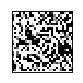

Iteration 2355000: loss=1.0409451078885468e-12 prediction=5 lr=0.1
Iteration 2360000: loss=1.0409451078885468e-12 prediction=5 lr=0.1
Iteration 2365000: loss=1.0409451078885468e-12 prediction=5 lr=0.1
Iteration 2370000: loss=1.0409451078885468e-12 prediction=5 lr=0.1
Iteration 2375000: loss=1.0373923942097463e-12 prediction=5 lr=0.1
Iteration 2380000: loss=1.0373923942097463e-12 prediction=5 lr=0.1
Iteration 2385000: loss=1.0373923942097463e-12 prediction=5 lr=0.1
Iteration 2390000: loss=1.0338396805309458e-12 prediction=5 lr=0.1
Iteration 2395000: loss=1.0338396805309458e-12 prediction=5 lr=0.1
Iteration 2400000: loss=1.0338396805309458e-12 prediction=5 lr=0.1


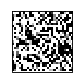

Iteration 2405000: loss=1.0302869668521453e-12 prediction=5 lr=0.1
Iteration 2410000: loss=1.0302869668521453e-12 prediction=5 lr=0.1
Iteration 2415000: loss=1.0302869668521453e-12 prediction=5 lr=0.1
Iteration 2420000: loss=1.0302869668521453e-12 prediction=5 lr=0.1
Iteration 2425000: loss=1.0267342531733448e-12 prediction=5 lr=0.1
Iteration 2430000: loss=1.0267342531733448e-12 prediction=5 lr=0.1
Iteration 2435000: loss=1.0267342531733448e-12 prediction=5 lr=0.1
Iteration 2440000: loss=1.0231815394945443e-12 prediction=5 lr=0.1
Iteration 2445000: loss=1.0231815394945443e-12 prediction=5 lr=0.1
Iteration 2450000: loss=1.0231815394945443e-12 prediction=5 lr=0.1


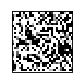

Iteration 2455000: loss=1.0231815394945443e-12 prediction=5 lr=0.1
Iteration 2460000: loss=1.0196288258157438e-12 prediction=5 lr=0.1
Iteration 2465000: loss=1.0196288258157438e-12 prediction=5 lr=0.1
Iteration 2470000: loss=1.0196288258157438e-12 prediction=5 lr=0.1
Iteration 2475000: loss=1.0160761121369433e-12 prediction=5 lr=0.1
Iteration 2480000: loss=1.0160761121369433e-12 prediction=5 lr=0.1
Iteration 2485000: loss=1.0160761121369433e-12 prediction=5 lr=0.1
Iteration 2490000: loss=1.0160761121369433e-12 prediction=5 lr=0.1
Iteration 2495000: loss=1.0125233984581428e-12 prediction=5 lr=0.1
Iteration 2500000: loss=1.0125233984581428e-12 prediction=5 lr=0.1


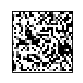

Iteration 2505000: loss=1.0125233984581428e-12 prediction=5 lr=0.1
Iteration 2510000: loss=1.0125233984581428e-12 prediction=5 lr=0.1
Iteration 2515000: loss=1.0089706847793423e-12 prediction=5 lr=0.1
Iteration 2520000: loss=1.0089706847793423e-12 prediction=5 lr=0.1
Iteration 2525000: loss=1.0089706847793423e-12 prediction=5 lr=0.1
Iteration 2530000: loss=1.0089706847793423e-12 prediction=5 lr=0.1
Iteration 2535000: loss=1.0054179711005418e-12 prediction=5 lr=0.1
Iteration 2540000: loss=1.0054179711005418e-12 prediction=5 lr=0.1
Iteration 2545000: loss=1.0054179711005418e-12 prediction=5 lr=0.1
Iteration 2550000: loss=1.0018652574217413e-12 prediction=5 lr=0.1


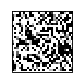

Iteration 2555000: loss=1.0018652574217413e-12 prediction=5 lr=0.1
Iteration 2560000: loss=1.0018652574217413e-12 prediction=5 lr=0.1
Iteration 2565000: loss=1.0018652574217413e-12 prediction=5 lr=0.1
Iteration 2570000: loss=9.983125437429408e-13 prediction=5 lr=0.1
Iteration 2575000: loss=9.983125437429408e-13 prediction=5 lr=0.1
Iteration 2580000: loss=9.983125437429408e-13 prediction=5 lr=0.1
Iteration 2585000: loss=9.983125437429408e-13 prediction=5 lr=0.1
Iteration 2590000: loss=9.947598300641403e-13 prediction=5 lr=0.1
Iteration 2595000: loss=9.947598300641403e-13 prediction=5 lr=0.1
Iteration 2600000: loss=9.947598300641403e-13 prediction=5 lr=0.1


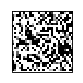

Iteration 2605000: loss=9.947598300641403e-13 prediction=5 lr=0.1
Iteration 2610000: loss=9.912071163853398e-13 prediction=5 lr=0.1
Iteration 2615000: loss=9.912071163853398e-13 prediction=5 lr=0.1
Iteration 2620000: loss=9.912071163853398e-13 prediction=5 lr=0.1
Iteration 2625000: loss=9.876544027065393e-13 prediction=5 lr=0.1
Iteration 2630000: loss=9.876544027065393e-13 prediction=5 lr=0.1
Iteration 2635000: loss=9.876544027065393e-13 prediction=5 lr=0.1
Iteration 2640000: loss=9.876544027065393e-13 prediction=5 lr=0.1
Iteration 2645000: loss=9.841016890277388e-13 prediction=5 lr=0.1
Iteration 2650000: loss=9.841016890277388e-13 prediction=5 lr=0.1


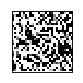

Iteration 2655000: loss=9.841016890277388e-13 prediction=5 lr=0.1
Iteration 2660000: loss=9.841016890277388e-13 prediction=5 lr=0.1
Iteration 2665000: loss=9.805489753489383e-13 prediction=5 lr=0.1
Iteration 2670000: loss=9.805489753489383e-13 prediction=5 lr=0.1
Iteration 2675000: loss=9.805489753489383e-13 prediction=5 lr=0.1
Iteration 2680000: loss=9.769962616701378e-13 prediction=5 lr=0.1
Iteration 2685000: loss=9.769962616701378e-13 prediction=5 lr=0.1
Iteration 2690000: loss=9.769962616701378e-13 prediction=5 lr=0.1
Iteration 2695000: loss=9.769962616701378e-13 prediction=5 lr=0.1
Iteration 2700000: loss=9.734435479913373e-13 prediction=5 lr=0.1


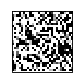

Iteration 2705000: loss=9.734435479913373e-13 prediction=5 lr=0.1
Iteration 2710000: loss=9.734435479913373e-13 prediction=5 lr=0.1
Iteration 2715000: loss=9.734435479913373e-13 prediction=5 lr=0.1
Iteration 2720000: loss=9.698908343125368e-13 prediction=5 lr=0.1
Iteration 2725000: loss=9.698908343125368e-13 prediction=5 lr=0.1
Iteration 2730000: loss=9.698908343125368e-13 prediction=5 lr=0.1
Iteration 2735000: loss=9.663381206337363e-13 prediction=5 lr=0.1
Iteration 2740000: loss=9.663381206337363e-13 prediction=5 lr=0.1
Iteration 2745000: loss=9.663381206337363e-13 prediction=5 lr=0.1
Iteration 2750000: loss=9.663381206337363e-13 prediction=5 lr=0.1


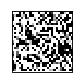

Iteration 2755000: loss=9.627854069549358e-13 prediction=5 lr=0.1
Iteration 2760000: loss=9.627854069549358e-13 prediction=5 lr=0.1
Iteration 2765000: loss=9.627854069549358e-13 prediction=5 lr=0.1
Iteration 2770000: loss=9.627854069549358e-13 prediction=5 lr=0.1
Iteration 2775000: loss=9.592326932761353e-13 prediction=5 lr=0.1
Iteration 2780000: loss=9.592326932761353e-13 prediction=5 lr=0.1
Iteration 2785000: loss=9.592326932761353e-13 prediction=5 lr=0.1
Iteration 2790000: loss=9.556799795973347e-13 prediction=5 lr=0.1
Iteration 2795000: loss=9.556799795973347e-13 prediction=5 lr=0.1
Iteration 2800000: loss=9.556799795973347e-13 prediction=5 lr=0.1


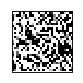

Iteration 2805000: loss=9.521272659185342e-13 prediction=5 lr=0.1
Iteration 2810000: loss=9.521272659185342e-13 prediction=5 lr=0.1
Iteration 2815000: loss=9.521272659185342e-13 prediction=5 lr=0.1
Iteration 2820000: loss=9.485745522397337e-13 prediction=5 lr=0.1
Iteration 2825000: loss=9.485745522397337e-13 prediction=5 lr=0.1
Iteration 2830000: loss=9.485745522397337e-13 prediction=5 lr=0.1
Iteration 2835000: loss=9.485745522397337e-13 prediction=5 lr=0.1
Iteration 2840000: loss=9.450218385609332e-13 prediction=5 lr=0.1
Iteration 2845000: loss=9.450218385609332e-13 prediction=5 lr=0.1
Iteration 2850000: loss=9.450218385609332e-13 prediction=5 lr=0.1


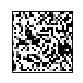

Iteration 2855000: loss=9.414691248821327e-13 prediction=5 lr=0.1
Iteration 2860000: loss=9.414691248821327e-13 prediction=5 lr=0.1
Iteration 2865000: loss=9.414691248821327e-13 prediction=5 lr=0.1
Iteration 2870000: loss=9.379164112033322e-13 prediction=5 lr=0.1
Iteration 2875000: loss=9.379164112033322e-13 prediction=5 lr=0.1
Iteration 2880000: loss=9.379164112033322e-13 prediction=5 lr=0.1
Iteration 2885000: loss=9.379164112033322e-13 prediction=5 lr=0.1
Iteration 2890000: loss=9.343636975245317e-13 prediction=5 lr=0.1
Iteration 2895000: loss=9.343636975245317e-13 prediction=5 lr=0.1
Iteration 2900000: loss=9.343636975245317e-13 prediction=5 lr=0.1


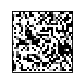

Iteration 2905000: loss=9.308109838457312e-13 prediction=5 lr=0.1
Iteration 2910000: loss=9.308109838457312e-13 prediction=5 lr=0.1
Iteration 2915000: loss=9.308109838457312e-13 prediction=5 lr=0.1
Iteration 2920000: loss=9.308109838457312e-13 prediction=5 lr=0.1
Iteration 2925000: loss=9.272582701669307e-13 prediction=5 lr=0.1
Iteration 2930000: loss=9.272582701669307e-13 prediction=5 lr=0.1
Iteration 2935000: loss=9.272582701669307e-13 prediction=5 lr=0.1
Iteration 2940000: loss=9.237055564881302e-13 prediction=5 lr=0.1
Iteration 2945000: loss=9.237055564881302e-13 prediction=5 lr=0.1
Iteration 2950000: loss=9.237055564881302e-13 prediction=5 lr=0.1


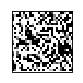

Iteration 2955000: loss=9.201528428093297e-13 prediction=5 lr=0.1
Iteration 2960000: loss=9.201528428093297e-13 prediction=5 lr=0.1
Iteration 2965000: loss=9.201528428093297e-13 prediction=5 lr=0.1
Iteration 2970000: loss=9.166001291305292e-13 prediction=5 lr=0.1
Iteration 2975000: loss=9.166001291305292e-13 prediction=5 lr=0.1
Iteration 2980000: loss=9.166001291305292e-13 prediction=5 lr=0.1
Iteration 2985000: loss=9.130474154517287e-13 prediction=5 lr=0.1
Iteration 2990000: loss=9.130474154517287e-13 prediction=5 lr=0.1
Iteration 2995000: loss=9.130474154517287e-13 prediction=5 lr=0.1
Iteration 3000000: loss=9.094947017729282e-13 prediction=5 lr=0.1


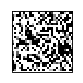

Iteration 3005000: loss=9.094947017729282e-13 prediction=5 lr=0.1
Iteration 3010000: loss=9.059419880941277e-13 prediction=5 lr=0.1
Iteration 3015000: loss=9.059419880941277e-13 prediction=5 lr=0.1
Iteration 3020000: loss=9.059419880941277e-13 prediction=5 lr=0.1
Iteration 3025000: loss=9.023892744153272e-13 prediction=5 lr=0.1
Iteration 3030000: loss=9.023892744153272e-13 prediction=5 lr=0.1
Iteration 3035000: loss=8.988365607365267e-13 prediction=5 lr=0.1
Iteration 3040000: loss=8.988365607365267e-13 prediction=5 lr=0.1
Iteration 3045000: loss=8.952838470577262e-13 prediction=5 lr=0.1
Iteration 3050000: loss=8.952838470577262e-13 prediction=5 lr=0.1


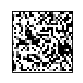

Iteration 3055000: loss=8.952838470577262e-13 prediction=5 lr=0.1
Iteration 3060000: loss=8.917311333789257e-13 prediction=5 lr=0.1
Iteration 3065000: loss=8.917311333789257e-13 prediction=5 lr=0.1
Iteration 3070000: loss=8.881784197001252e-13 prediction=5 lr=0.1
Iteration 3075000: loss=8.846257060213247e-13 prediction=5 lr=0.1
Iteration 3080000: loss=8.846257060213247e-13 prediction=5 lr=0.1
Iteration 3085000: loss=8.810729923425242e-13 prediction=5 lr=0.1
Iteration 3090000: loss=8.810729923425242e-13 prediction=5 lr=0.1
Iteration 3095000: loss=8.775202786637237e-13 prediction=5 lr=0.1
Iteration 3100000: loss=8.739675649849232e-13 prediction=5 lr=0.1


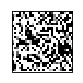

Iteration 3105000: loss=8.704148513061227e-13 prediction=5 lr=0.1
Iteration 3110000: loss=8.704148513061227e-13 prediction=5 lr=0.1
Iteration 3115000: loss=8.668621376273222e-13 prediction=5 lr=0.1
Iteration 3120000: loss=8.633094239485217e-13 prediction=5 lr=0.1
Iteration 3125000: loss=8.633094239485217e-13 prediction=5 lr=0.1
Iteration 3130000: loss=8.597567102697212e-13 prediction=5 lr=0.1
Iteration 3135000: loss=8.597567102697212e-13 prediction=5 lr=0.1
Iteration 3140000: loss=8.562039965909207e-13 prediction=5 lr=0.1
Iteration 3145000: loss=8.526512829121202e-13 prediction=5 lr=0.1
Iteration 3150000: loss=8.526512829121202e-13 prediction=5 lr=0.1


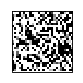

Iteration 3155000: loss=8.490985692333197e-13 prediction=5 lr=0.1
Iteration 3160000: loss=8.455458555545192e-13 prediction=5 lr=0.1
Iteration 3165000: loss=8.455458555545192e-13 prediction=5 lr=0.1
Iteration 3170000: loss=8.419931418757187e-13 prediction=5 lr=0.1
Iteration 3175000: loss=8.384404281969182e-13 prediction=5 lr=0.1
Iteration 3180000: loss=8.384404281969182e-13 prediction=5 lr=0.1
Iteration 3185000: loss=8.348877145181177e-13 prediction=5 lr=0.1
Iteration 3190000: loss=8.313350008393172e-13 prediction=5 lr=0.1
Iteration 3195000: loss=8.277822871605167e-13 prediction=5 lr=0.1
Iteration 3200000: loss=8.242295734817162e-13 prediction=5 lr=0.1


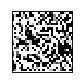

Iteration 3205000: loss=8.206768598029157e-13 prediction=5 lr=0.1
Iteration 3210000: loss=8.206768598029157e-13 prediction=5 lr=0.1
Iteration 3215000: loss=8.171241461241152e-13 prediction=5 lr=0.1
Iteration 3220000: loss=8.135714324453147e-13 prediction=5 lr=0.1
Iteration 3225000: loss=8.100187187665142e-13 prediction=5 lr=0.1
Iteration 3230000: loss=8.064660050877137e-13 prediction=5 lr=0.1
Iteration 3235000: loss=8.029132914089132e-13 prediction=5 lr=0.1
Iteration 3240000: loss=7.993605777301127e-13 prediction=5 lr=0.1
Iteration 3245000: loss=7.922551503725117e-13 prediction=5 lr=0.1
Iteration 3250000: loss=7.887024366937112e-13 prediction=5 lr=0.1


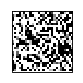

Iteration 3255000: loss=7.851497230149107e-13 prediction=5 lr=0.1
Iteration 3260000: loss=7.815970093361102e-13 prediction=5 lr=0.1
Iteration 3265000: loss=7.780442956573097e-13 prediction=5 lr=0.1
Iteration 3270000: loss=7.744915819785092e-13 prediction=5 lr=0.1
Iteration 3275000: loss=7.673861546209082e-13 prediction=5 lr=0.1
Iteration 3280000: loss=7.638334409421077e-13 prediction=5 lr=0.1
Iteration 3285000: loss=7.602807272633072e-13 prediction=5 lr=0.1
Iteration 3290000: loss=7.567280135845067e-13 prediction=5 lr=0.1
Iteration 3295000: loss=7.531752999057062e-13 prediction=5 lr=0.1
Iteration 3300000: loss=7.460698725481052e-13 prediction=5 lr=0.1


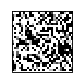

Iteration 3305000: loss=7.425171588693047e-13 prediction=5 lr=0.1
Iteration 3310000: loss=7.389644451905042e-13 prediction=5 lr=0.1
Iteration 3315000: loss=7.354117315117037e-13 prediction=5 lr=0.1
Iteration 3320000: loss=7.283063041541027e-13 prediction=5 lr=0.1
Iteration 3325000: loss=7.247535904753022e-13 prediction=5 lr=0.1
Iteration 3330000: loss=7.212008767965017e-13 prediction=5 lr=0.1
Iteration 3335000: loss=7.176481631177012e-13 prediction=5 lr=0.1
Iteration 3340000: loss=7.140954494389007e-13 prediction=5 lr=0.1
Iteration 3345000: loss=7.069900220812997e-13 prediction=5 lr=0.1
Iteration 3350000: loss=7.034373084024992e-13 prediction=5 lr=0.1


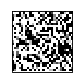

Iteration 3355000: loss=6.998845947236987e-13 prediction=5 lr=0.1
Iteration 3360000: loss=6.927791673660977e-13 prediction=5 lr=0.1
Iteration 3365000: loss=6.892264536872972e-13 prediction=5 lr=0.1
Iteration 3370000: loss=6.856737400084967e-13 prediction=5 lr=0.1
Iteration 3375000: loss=6.785683126508957e-13 prediction=5 lr=0.1
Iteration 3380000: loss=6.750155989720952e-13 prediction=5 lr=0.1
Iteration 3385000: loss=6.679101716144942e-13 prediction=5 lr=0.1
Iteration 3390000: loss=6.643574579356937e-13 prediction=5 lr=0.1
Iteration 3395000: loss=6.572520305780927e-13 prediction=5 lr=0.1
Iteration 3400000: loss=6.501466032204917e-13 prediction=5 lr=0.1


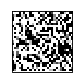

Iteration 3405000: loss=6.430411758628907e-13 prediction=5 lr=0.1
Iteration 3410000: loss=6.359357485052897e-13 prediction=5 lr=0.1
Iteration 3415000: loss=6.323830348264892e-13 prediction=5 lr=0.1
Iteration 3420000: loss=6.252776074688882e-13 prediction=5 lr=0.1
Iteration 3425000: loss=6.181721801112872e-13 prediction=5 lr=0.1
Iteration 3430000: loss=6.110667527536862e-13 prediction=5 lr=0.1
Iteration 3435000: loss=6.075140390748857e-13 prediction=5 lr=0.1
Iteration 3440000: loss=6.004086117172847e-13 prediction=5 lr=0.1
Iteration 3445000: loss=5.968558980384842e-13 prediction=5 lr=0.1
Iteration 3450000: loss=5.933031843596837e-13 prediction=5 lr=0.1


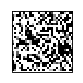

Iteration 3455000: loss=5.897504706808832e-13 prediction=5 lr=0.1
Iteration 3460000: loss=5.861977570020827e-13 prediction=5 lr=0.1
Iteration 3465000: loss=5.861977570020827e-13 prediction=5 lr=0.1
Iteration 3470000: loss=5.826450433232822e-13 prediction=5 lr=0.1
Iteration 3475000: loss=5.790923296444817e-13 prediction=5 lr=0.1
Iteration 3480000: loss=5.790923296444817e-13 prediction=5 lr=0.1
Iteration 3485000: loss=5.755396159656812e-13 prediction=5 lr=0.1
Iteration 3490000: loss=5.755396159656812e-13 prediction=5 lr=0.1
Iteration 3495000: loss=5.719869022868806e-13 prediction=5 lr=0.1
Iteration 3500000: loss=5.719869022868806e-13 prediction=5 lr=0.1


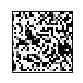

Iteration 3505000: loss=5.684341886080801e-13 prediction=5 lr=0.1
Iteration 3510000: loss=5.684341886080801e-13 prediction=5 lr=0.1
Iteration 3515000: loss=5.648814749292796e-13 prediction=5 lr=0.1
Iteration 3520000: loss=5.648814749292796e-13 prediction=5 lr=0.1
Iteration 3525000: loss=5.648814749292796e-13 prediction=5 lr=0.1
Iteration 3530000: loss=5.613287612504791e-13 prediction=5 lr=0.1
Iteration 3535000: loss=5.613287612504791e-13 prediction=5 lr=0.1
Iteration 3540000: loss=5.613287612504791e-13 prediction=5 lr=0.1
Iteration 3545000: loss=5.577760475716786e-13 prediction=5 lr=0.1
Iteration 3550000: loss=5.577760475716786e-13 prediction=5 lr=0.1


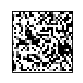

Iteration 3555000: loss=5.577760475716786e-13 prediction=5 lr=0.1
Iteration 3560000: loss=5.542233338928781e-13 prediction=5 lr=0.1
Iteration 3565000: loss=5.542233338928781e-13 prediction=5 lr=0.1
Iteration 3570000: loss=5.542233338928781e-13 prediction=5 lr=0.1
Iteration 3575000: loss=5.542233338928781e-13 prediction=5 lr=0.1
Iteration 3580000: loss=5.506706202140776e-13 prediction=5 lr=0.1
Iteration 3585000: loss=5.506706202140776e-13 prediction=5 lr=0.1
Iteration 3590000: loss=5.506706202140776e-13 prediction=5 lr=0.1
Iteration 3595000: loss=5.506706202140776e-13 prediction=5 lr=0.1
Iteration 3600000: loss=5.471179065352771e-13 prediction=5 lr=0.1


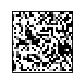

Iteration 3605000: loss=5.471179065352771e-13 prediction=5 lr=0.1
Iteration 3610000: loss=5.471179065352771e-13 prediction=5 lr=0.1
Iteration 3615000: loss=5.471179065352771e-13 prediction=5 lr=0.1
Iteration 3620000: loss=5.471179065352771e-13 prediction=5 lr=0.1
Iteration 3625000: loss=5.471179065352771e-13 prediction=5 lr=0.1
Decreasing LR ..
Iteration 3630000: loss=5.435651928564766e-13 prediction=5 lr=0.05
Iteration 3635000: loss=5.435651928564766e-13 prediction=5 lr=0.05
Iteration 3640000: loss=5.435651928564766e-13 prediction=5 lr=0.05
Iteration 3645000: loss=5.435651928564766e-13 prediction=5 lr=0.05
Iteration 3650000: loss=5.435651928564766e-13 prediction=5 lr=0.05


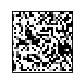

Iteration 3655000: loss=5.435651928564766e-13 prediction=5 lr=0.05
Iteration 3660000: loss=5.435651928564766e-13 prediction=5 lr=0.05
Iteration 3665000: loss=5.435651928564766e-13 prediction=5 lr=0.05
Iteration 3670000: loss=5.435651928564766e-13 prediction=5 lr=0.05
Iteration 3675000: loss=5.435651928564766e-13 prediction=5 lr=0.05
Iteration 3680000: loss=5.435651928564766e-13 prediction=5 lr=0.05
Decreasing LR ..
Iteration 3685000: loss=5.435651928564766e-13 prediction=5 lr=0.025
Iteration 3690000: loss=5.435651928564766e-13 prediction=5 lr=0.025
Iteration 3695000: loss=5.435651928564766e-13 prediction=5 lr=0.025
Iteration 3700000: loss=5.435651928564766e-13 prediction=5 lr=0.025


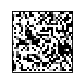

Iteration 3705000: loss=5.435651928564766e-13 prediction=5 lr=0.025
Iteration 3710000: loss=5.435651928564766e-13 prediction=5 lr=0.025
Iteration 3715000: loss=5.435651928564766e-13 prediction=5 lr=0.025
Iteration 3720000: loss=5.435651928564766e-13 prediction=5 lr=0.025
Iteration 3725000: loss=5.435651928564766e-13 prediction=5 lr=0.025
Iteration 3730000: loss=5.435651928564766e-13 prediction=5 lr=0.025
Iteration 3735000: loss=5.435651928564766e-13 prediction=5 lr=0.025
Decreasing LR ..
Iteration 3740000: loss=5.435651928564766e-13 prediction=5 lr=0.0125
Iteration 3745000: loss=5.435651928564766e-13 prediction=5 lr=0.0125
Iteration 3750000: loss=5.435651928564766e-13 prediction=5 lr=0.0125


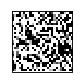

Iteration 3755000: loss=5.435651928564766e-13 prediction=5 lr=0.0125
Iteration 3760000: loss=5.435651928564766e-13 prediction=5 lr=0.0125
Iteration 3765000: loss=5.435651928564766e-13 prediction=5 lr=0.0125
Iteration 3770000: loss=5.435651928564766e-13 prediction=5 lr=0.0125
Iteration 3775000: loss=5.435651928564766e-13 prediction=5 lr=0.0125
Iteration 3780000: loss=5.435651928564766e-13 prediction=5 lr=0.0125
Iteration 3785000: loss=5.435651928564766e-13 prediction=5 lr=0.0125
Iteration 3790000: loss=5.435651928564766e-13 prediction=5 lr=0.0125
Decreasing LR ..
Iteration 3795000: loss=5.435651928564766e-13 prediction=5 lr=0.00625
Iteration 3800000: loss=5.435651928564766e-13 prediction=5 lr=0.00625


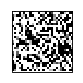

Iteration 3805000: loss=5.435651928564766e-13 prediction=5 lr=0.00625
Iteration 3810000: loss=5.435651928564766e-13 prediction=5 lr=0.00625
Iteration 3815000: loss=5.435651928564766e-13 prediction=5 lr=0.00625
Iteration 3820000: loss=5.435651928564766e-13 prediction=5 lr=0.00625
Iteration 3825000: loss=5.435651928564766e-13 prediction=5 lr=0.00625
Iteration 3830000: loss=5.435651928564766e-13 prediction=5 lr=0.00625
Iteration 3835000: loss=5.435651928564766e-13 prediction=5 lr=0.00625
Iteration 3840000: loss=5.435651928564766e-13 prediction=5 lr=0.00625
Iteration 3845000: loss=5.435651928564766e-13 prediction=5 lr=0.00625
Decreasing LR ..
Iteration 3850000: loss=5.435651928564766e-13 prediction=5 lr=0.003125


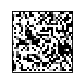

Iteration 3855000: loss=5.435651928564766e-13 prediction=5 lr=0.003125
Iteration 3860000: loss=5.435651928564766e-13 prediction=5 lr=0.003125
Iteration 3865000: loss=5.435651928564766e-13 prediction=5 lr=0.003125
Iteration 3870000: loss=5.435651928564766e-13 prediction=5 lr=0.003125
Iteration 3875000: loss=5.435651928564766e-13 prediction=5 lr=0.003125
Iteration 3880000: loss=5.435651928564766e-13 prediction=5 lr=0.003125
Iteration 3885000: loss=5.435651928564766e-13 prediction=5 lr=0.003125
Iteration 3890000: loss=5.435651928564766e-13 prediction=5 lr=0.003125
Iteration 3895000: loss=5.435651928564766e-13 prediction=5 lr=0.003125
Iteration 3900000: loss=5.435651928564766e-13 prediction=5 lr=0.003125
Decreasing LR ..


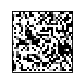

Iteration 3905000: loss=5.435651928564766e-13 prediction=5 lr=0.0015625
Iteration 3910000: loss=5.435651928564766e-13 prediction=5 lr=0.0015625
Iteration 3915000: loss=5.435651928564766e-13 prediction=5 lr=0.0015625
Iteration 3920000: loss=5.435651928564766e-13 prediction=5 lr=0.0015625
Iteration 3925000: loss=5.435651928564766e-13 prediction=5 lr=0.0015625
Iteration 3930000: loss=5.435651928564766e-13 prediction=5 lr=0.0015625
Iteration 3935000: loss=5.435651928564766e-13 prediction=5 lr=0.0015625
Iteration 3940000: loss=5.435651928564766e-13 prediction=5 lr=0.0015625
Iteration 3945000: loss=5.435651928564766e-13 prediction=5 lr=0.0015625
Iteration 3950000: loss=5.435651928564766e-13 prediction=5 lr=0.0015625


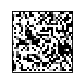

Iteration 3955000: loss=5.435651928564766e-13 prediction=5 lr=0.0015625
Decreasing LR ..
Iteration 3960000: loss=5.435651928564766e-13 prediction=5 lr=0.00078125
Iteration 3965000: loss=5.435651928564766e-13 prediction=5 lr=0.00078125
Iteration 3970000: loss=5.435651928564766e-13 prediction=5 lr=0.00078125
Iteration 3975000: loss=5.435651928564766e-13 prediction=5 lr=0.00078125
Iteration 3980000: loss=5.435651928564766e-13 prediction=5 lr=0.00078125
Iteration 3985000: loss=5.435651928564766e-13 prediction=5 lr=0.00078125
Iteration 3990000: loss=5.435651928564766e-13 prediction=5 lr=0.00078125
Iteration 3995000: loss=5.435651928564766e-13 prediction=5 lr=0.00078125
Iteration 4000000: loss=5.435651928564766e-13 prediction=5 lr=0.00078125


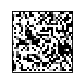

Iteration 4005000: loss=5.435651928564766e-13 prediction=5 lr=0.00078125
Iteration 4010000: loss=5.435651928564766e-13 prediction=5 lr=0.00078125
Decreasing LR ..
Iteration 4015000: loss=5.435651928564766e-13 prediction=5 lr=0.000390625
Iteration 4020000: loss=5.435651928564766e-13 prediction=5 lr=0.000390625
Iteration 4025000: loss=5.435651928564766e-13 prediction=5 lr=0.000390625
Iteration 4030000: loss=5.435651928564766e-13 prediction=5 lr=0.000390625
Iteration 4035000: loss=5.435651928564766e-13 prediction=5 lr=0.000390625
Iteration 4040000: loss=5.435651928564766e-13 prediction=5 lr=0.000390625
Iteration 4045000: loss=5.435651928564766e-13 prediction=5 lr=0.000390625
Iteration 4050000: loss=5.435651928564766e-13 prediction=5 lr=0.000390625


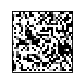

Iteration 4055000: loss=5.435651928564766e-13 prediction=5 lr=0.000390625
Iteration 4060000: loss=5.435651928564766e-13 prediction=5 lr=0.000390625
Iteration 4065000: loss=5.435651928564766e-13 prediction=5 lr=0.000390625
Decreasing LR ..
Iteration 4070000: loss=5.435651928564766e-13 prediction=5 lr=0.0001953125
Iteration 4075000: loss=5.435651928564766e-13 prediction=5 lr=0.0001953125
Iteration 4080000: loss=5.435651928564766e-13 prediction=5 lr=0.0001953125
Iteration 4085000: loss=5.435651928564766e-13 prediction=5 lr=0.0001953125
Iteration 4090000: loss=5.435651928564766e-13 prediction=5 lr=0.0001953125
Iteration 4095000: loss=5.435651928564766e-13 prediction=5 lr=0.0001953125
Iteration 4100000: loss=5.435651928564766e-13 prediction=5 lr=0.0001953125


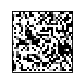

Iteration 4105000: loss=5.435651928564766e-13 prediction=5 lr=0.0001953125
Iteration 4110000: loss=5.435651928564766e-13 prediction=5 lr=0.0001953125
Iteration 4115000: loss=5.435651928564766e-13 prediction=5 lr=0.0001953125
Iteration 4120000: loss=5.435651928564766e-13 prediction=5 lr=0.0001953125
Decreasing LR ..
Iteration 4125000: loss=5.435651928564766e-13 prediction=5 lr=9.765625e-05
Iteration 4130000: loss=5.435651928564766e-13 prediction=5 lr=9.765625e-05
Iteration 4135000: loss=5.435651928564766e-13 prediction=5 lr=9.765625e-05
Iteration 4140000: loss=5.435651928564766e-13 prediction=5 lr=9.765625e-05
Iteration 4145000: loss=5.435651928564766e-13 prediction=5 lr=9.765625e-05
Iteration 4150000: loss=5.435651928564766e-13 prediction=5 lr=9.765625e-05


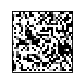

Iteration 4155000: loss=5.435651928564766e-13 prediction=5 lr=9.765625e-05
Iteration 4160000: loss=5.435651928564766e-13 prediction=5 lr=9.765625e-05
Iteration 4165000: loss=5.435651928564766e-13 prediction=5 lr=9.765625e-05
Iteration 4170000: loss=5.435651928564766e-13 prediction=5 lr=9.765625e-05
Iteration 4175000: loss=5.435651928564766e-13 prediction=5 lr=9.765625e-05
Decreasing LR ..
Iteration 4180000: loss=5.435651928564766e-13 prediction=5 lr=4.8828125e-05
Iteration 4185000: loss=5.435651928564766e-13 prediction=5 lr=4.8828125e-05
Iteration 4190000: loss=5.435651928564766e-13 prediction=5 lr=4.8828125e-05
Iteration 4195000: loss=5.435651928564766e-13 prediction=5 lr=4.8828125e-05
Iteration 4200000: loss=5.435651928564766e-13 prediction=5 lr=4.8828125e-05


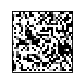

Iteration 4205000: loss=5.435651928564766e-13 prediction=5 lr=4.8828125e-05
Iteration 4210000: loss=5.435651928564766e-13 prediction=5 lr=4.8828125e-05
Iteration 4215000: loss=5.435651928564766e-13 prediction=5 lr=4.8828125e-05
Iteration 4220000: loss=5.435651928564766e-13 prediction=5 lr=4.8828125e-05
Iteration 4225000: loss=5.435651928564766e-13 prediction=5 lr=4.8828125e-05
Iteration 4230000: loss=5.435651928564766e-13 prediction=5 lr=4.8828125e-05
Decreasing LR ..
Iteration 4235000: loss=5.435651928564766e-13 prediction=5 lr=2.44140625e-05
Iteration 4240000: loss=5.435651928564766e-13 prediction=5 lr=2.44140625e-05
Iteration 4245000: loss=5.435651928564766e-13 prediction=5 lr=2.44140625e-05
Iteration 4250000: loss=5.435651928564766e-13 prediction=5 lr=2.44140625e-05


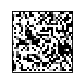

Iteration 4255000: loss=5.435651928564766e-13 prediction=5 lr=2.44140625e-05
Iteration 4260000: loss=5.435651928564766e-13 prediction=5 lr=2.44140625e-05
Iteration 4265000: loss=5.435651928564766e-13 prediction=5 lr=2.44140625e-05
Iteration 4270000: loss=5.435651928564766e-13 prediction=5 lr=2.44140625e-05
Iteration 4275000: loss=5.435651928564766e-13 prediction=5 lr=2.44140625e-05
Iteration 4280000: loss=5.435651928564766e-13 prediction=5 lr=2.44140625e-05
Iteration 4285000: loss=5.435651928564766e-13 prediction=5 lr=2.44140625e-05
Decreasing LR ..
Iteration 4290000: loss=5.435651928564766e-13 prediction=5 lr=1.220703125e-05
Iteration 4295000: loss=5.435651928564766e-13 prediction=5 lr=1.220703125e-05
Iteration 4300000: loss=5.435651928564766e-13 prediction=5 lr=1.220703125e-05


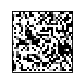

Iteration 4305000: loss=5.435651928564766e-13 prediction=5 lr=1.220703125e-05
Iteration 4310000: loss=5.435651928564766e-13 prediction=5 lr=1.220703125e-05
Iteration 4315000: loss=5.435651928564766e-13 prediction=5 lr=1.220703125e-05
Iteration 4320000: loss=5.435651928564766e-13 prediction=5 lr=1.220703125e-05
Iteration 4325000: loss=5.435651928564766e-13 prediction=5 lr=1.220703125e-05
Iteration 4330000: loss=5.435651928564766e-13 prediction=5 lr=1.220703125e-05
Iteration 4335000: loss=5.435651928564766e-13 prediction=5 lr=1.220703125e-05
Iteration 4340000: loss=5.435651928564766e-13 prediction=5 lr=1.220703125e-05
Decreasing LR ..
Iteration 4345000: loss=5.435651928564766e-13 prediction=5 lr=6.103515625e-06
Iteration 4350000: loss=5.435651928564766e-13 prediction=5 lr=6.103515625e-06


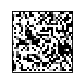

Iteration 4355000: loss=5.435651928564766e-13 prediction=5 lr=6.103515625e-06
Iteration 4360000: loss=5.435651928564766e-13 prediction=5 lr=6.103515625e-06
Iteration 4365000: loss=5.435651928564766e-13 prediction=5 lr=6.103515625e-06
Iteration 4370000: loss=5.435651928564766e-13 prediction=5 lr=6.103515625e-06
Iteration 4375000: loss=5.435651928564766e-13 prediction=5 lr=6.103515625e-06
Iteration 4380000: loss=5.435651928564766e-13 prediction=5 lr=6.103515625e-06
Iteration 4385000: loss=5.435651928564766e-13 prediction=5 lr=6.103515625e-06
Iteration 4390000: loss=5.435651928564766e-13 prediction=5 lr=6.103515625e-06
Iteration 4395000: loss=5.435651928564766e-13 prediction=5 lr=6.103515625e-06
Decreasing LR ..
Iteration 4400000: loss=5.435651928564766e-13 prediction=5 lr=3.0517578125e-06


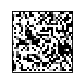

Iteration 4405000: loss=5.435651928564766e-13 prediction=5 lr=3.0517578125e-06
Iteration 4410000: loss=5.435651928564766e-13 prediction=5 lr=3.0517578125e-06


KeyboardInterrupt: 

In [19]:
new_image_randn, loss_stats = generate_image(img, 5)

In [ ]:
to_plot = new_image_randn[0].view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))